# Analyzing LA Fire Regions Using NASA's PACE OCI Satellite Data

### Imports and Set Up

In [1]:
import os
import re
import numpy as np
import earthaccess
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

c:\Users\katel\OneDrive\Desktop\pace-wildlife\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the curent working directory to \pace-wildlife
os.chdir("..")
# print("Current directory:", os.getcwd())
from src.downloader.pace_data_downloader import PaceDataDownloader

### Downloading PACE Data

In [3]:
# Download the data if not already downloaded
auth = earthaccess.login(persist=True)

dates = ("2024-12-01", "2025-04-30")
pacific_pal_bbox = (-118.75, 33.90, -118.45, 34.15)
downloader = PaceDataDownloader(bounding_box=pacific_pal_bbox, time_span=dates)

# Download PACE OCI data:
downloader.download_data("PACE_OCI_L2_BGC_NRT", max_count=200, version=3.0)
downloader.download_data("PACE_OCI_L2_AOP_NRT", max_count=200)
downloader.download_data("PACE_OCI_L2_LANDVI_NRT", max_count=200)

Found 143 results


QUEUEING TASKS | : 100%|██████████| 143/143 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████| 143/143 [01:11<00:00,  2.00it/s]
COLLECTING RESULTS | : 100%|██████████| 143/143 [00:00<?, ?it/s]


Found 143 results


QUEUEING TASKS | : 100%|██████████| 143/143 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████| 143/143 [18:22<00:00,  7.71s/it]
COLLECTING RESULTS | : 100%|██████████| 143/143 [00:00<?, ?it/s]


Found 143 results


QUEUEING TASKS | : 100%|██████████| 143/143 [00:00<00:00, 20162.21it/s]
PROCESSING TASKS | : 100%|██████████| 143/143 [03:45<00:00,  1.57s/it]
COLLECTING RESULTS | : 100%|██████████| 143/143 [00:00<?, ?it/s]


The data seems to start at Jan 4, 2025. There aren't any results for any dates in December for the Level 2 data products for PACE OCI: BGC, AOP, and LANDVI.

### Functions to Load Data

In [ ]:
def load_dataset_with_vars(file_path, variables_of_interest) -> 'xr.Dataset':
    """This function loads a single .nc data file into an xarray with the variables of interest."""
    # Open the dataset with the group containing the data variables
    ds_data = xr.open_dataset(file_path, group="geophysical_data")

    # Select only the variables of interest
    selected_vars = ds_data[variables_of_interest]

    # Open the dataset with the navigation data (for lat/lon)
    ds_nav = xr.open_dataset(file_path, group="navigation_data")
    ds_nav = ds_nav.set_coords(("longitude", "latitude"))

    # Merge selected variables with the coordinates
    merged_ds = xr.merge([selected_vars, ds_nav.coords])
    print(merged_ds)
    return merged_ds

In [6]:
test_file = Path("data/PACE_OCI_L2_BGC_NRT/PACE_OCI.20250104T202321.L2.OC_BGC.V3_0.NRT.nc")
load_dataset_with_vars(test_file, ["carbon_phyto", "chlor_a", "poc"])

<xarray.Dataset> Size: 44MB
Dimensions:       (number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 9MB ...
    latitude      (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a       (number_of_lines, pixels_per_line) float32 9MB ...
    poc           (number_of_lines, pixels_per_line) float32 9MB ...


<xarray.Dataset> Size: 44MB
Dimensions:       (number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 9MB ...
    latitude      (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a       (number_of_lines, pixels_per_line) float32 9MB ...
    poc           (number_of_lines, pixels_per_line) float32 9MB ...

In [7]:
def extract_time_from_filename(filename):
    # Example: '...20240509T1230Z.nc' → datetime object
    match = re.search(r'(\d{8}T\d{4})', filename)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%dT%H%M')
    else:
        raise ValueError(f"Timestamp not found in {filename}")

def load_merged_dataset(data_dir, variables_of_interest) -> 'xr.Dataset':
    """
    Loads .nc files from a data directory for an instrument and area of interest
    and extracts the coordinates and variables of interest. Merges all the data together
    with a new time coordinate and returns an xarray dataset.
    """
    datasets = []
    for file_path in data_dir.iterdir():
        try:
            # Open data variables from geophysical group
            ds_data = xr.open_dataset(file_path, group="geophysical_data")
            selected_vars = ds_data[variables_of_interest]

            # Open coordinates from navigation group
            ds_nav = xr.open_dataset(file_path, group="navigation_data")
            ds_nav = ds_nav.set_coords(("longitude", "latitude"))

            # Merge variables with coordinates
            merged = xr.merge([selected_vars, ds_nav.coords])

            time_value = extract_time_from_filename(file_path.stem)
            merged = merged.expand_dims(time=[time_value])

            datasets.append(merged)

        except Exception as e:
            print(f"Skipping file {file_path.name}: {e}")
            continue

    min_lines = min(ds.sizes['number_of_lines'] for ds in datasets)

    datasets_trimmed = [
        ds.isel(number_of_lines=slice(0, min_lines)) for ds in datasets
    ]

    # Concatenate along the time dimension
    combined = xr.concat(datasets_trimmed, dim="time")
    return combined

In [22]:
aop_dir = Path("data/PACE_OCI_L2_AOP_NRT")
bgc_dir = Path("data/PACE_OCI_L2_BGC_NRT")
landvi_dir = Path("data/PACE_OCI_L2_LANDVI_NRT")

pacific_pal_bbox = (-118.75, 33.90, -118.45, 34.15)

### BGC (Biogeochemical) Data - Chlorophyll, Phytoplankton, Carbon

In [8]:
bgc_merged_ds = load_merged_dataset(bgc_dir, ["carbon_phyto", "chlor_a", "poc"])
bgc_merged_ds

Skipping file PACE_OCI.20250302T205129.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250302T205129.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250309T200459.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250309T200459.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250310T204032.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250310T204032.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250311T193741.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250311T193741.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250312T201313.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 136, number_of_lines: 1709, pixels_per_line: 1272)
Coordinates:
  * time          (time) datetime64[ns] 1kB 2025-01-04T20:23:00 ... 2025-04-3...
    longitude     (time, number_of_lines, pixels_per_line) float32 1GB -126.2...
    latitude      (time, number_of_lines, pixels_per_line) float32 1GB 16.3 ....
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (time, number_of_lines, pixels_per_line) float32 1GB nan .....
    chlor_a       (time, number_of_lines, pixels_per_line) float32 1GB nan .....
    poc           (time, number_of_lines, pixels_per_line) float32 1GB nan .....

In [ ]:
# TODO: show some plots of the variables

In [ ]:
def summarize_variable_in_bbox(ds, var_name, bbox):
    lon_min, lat_min, lon_max, lat_max = bbox

    times = ds['time'].values
    results = []

    for t in range(len(times)):
        # Select the time slice
        var_slice = ds[var_name].isel(time=t)
        lat = ds['latitude'].isel(time=t).values
        lon = ds['longitude'].isel(time=t).values

        # Create bounding box mask
        mask = (
            (lon >= lon_min) & (lon <= lon_max) &
            (lat >= lat_min) & (lat <= lat_max)
        )

        # Apply mask
        data_vals = var_slice.values[mask]

        # Compute stats
        valid_pixels = np.count_nonzero(~np.isnan(data_vals))
        nan_pixels = np.count_nonzero(np.isnan(data_vals))
        mean_val = np.nanmean(data_vals) if valid_pixels > 0 else np.nan

        results.append({
            "time": str(times[t]),
            "mean_value": mean_val,
            "valid_pixels": valid_pixels,
            "nan_pixels": nan_pixels
        })

    return results

avg_pixel_vals = summarize_variable_in_bbox(bgc_merged_ds, "chlor_a", pacific_pal_bbox)
avg_pixel_vals

[{'time': '2025-01-04T20:23:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 556},
 {'time': '2025-01-05T20:58:00.000000000',
  'mean_value': np.float32(1.6612492),
  'valid_pixels': 6,
  'nan_pixels': 262},
 {'time': '2025-01-06T19:54:00.000000000',
  'mean_value': np.float32(9.239508),
  'valid_pixels': 112,
  'nan_pixels': 130},
 {'time': '2025-01-07T20:29:00.000000000',
  'mean_value': np.float32(4.5048604),
  'valid_pixels': 152,
  'nan_pixels': 412},
 {'time': '2025-01-08T21:03:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 214},
 {'time': '2025-01-09T20:00:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 299},
 {'time': '2025-01-10T20:35:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 531},
 {'time': '2025-01-11T19:36:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 104},
 {'time': '2025-01-11T21:09:00.000000000',
  'mean_value': np.float32(1.8831673),
  'va

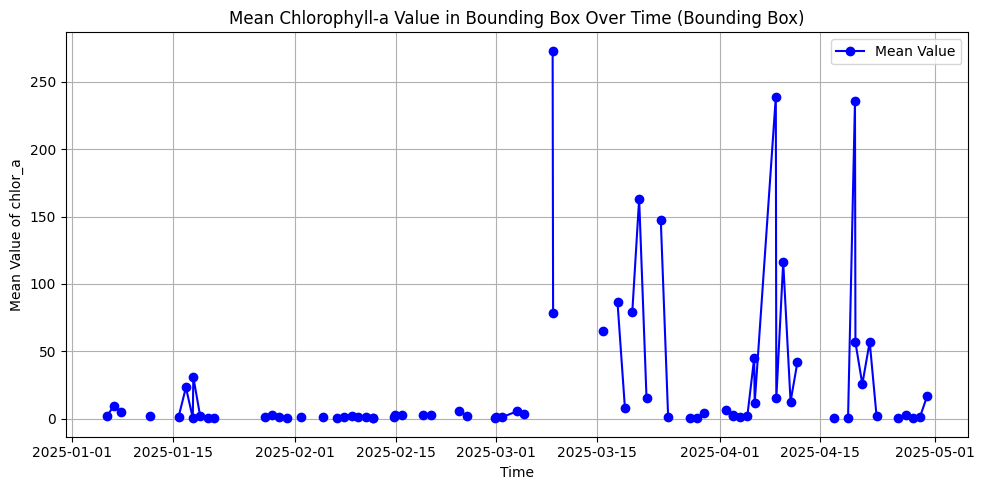

In [12]:
df = pd.DataFrame(avg_pixel_vals)

df['time'] = pd.to_datetime(df['time'])

# Sort by time (optional)
df = df.sort_values('time')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['mean_value'], marker='o', linestyle='-', color='blue', label='Mean Value')
plt.xlabel('Time')
plt.ylabel('Mean Value of chlor_a')
plt.title('Mean Chlorophyll-a Value in Bounding Box Over Time (Bounding Box)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

There are a lot of missing variables, but it seems that there's a spike from Jan 15 to Jan 22, which is about a week after the fires started. In March and April, there are much higher values of chlor_a. However, there is a bit of fluctuation between the measurements of different days in that time range, which suggests missing or skewed data affecting the measurements.

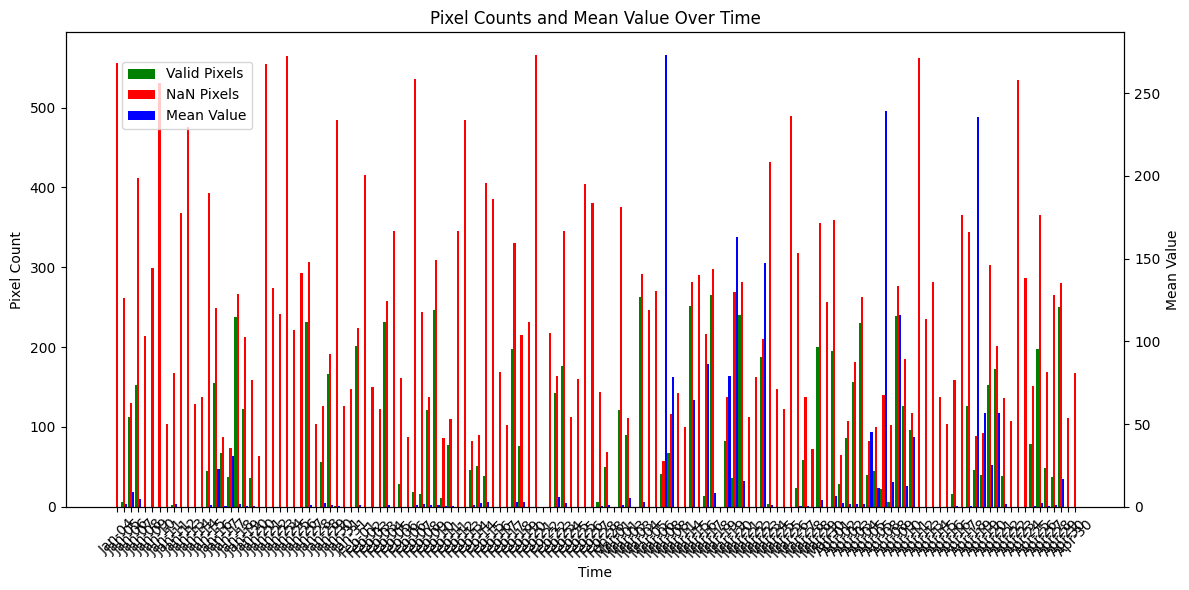

In [13]:
# Set figure and width of bars
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.3
x = np.arange(len(df))

# Plot valid and nan pixels
ax1.bar(x - bar_width, df['valid_pixels'], width=bar_width, label='Valid Pixels', color='green')
ax1.bar(x, df['nan_pixels'], width=bar_width, label='NaN Pixels', color='red')
ax1.set_ylabel('Pixel Count')
ax1.set_xlabel('Time')
ax1.set_xticks(x)
ax1.set_xticklabels(df['time'].dt.strftime('%b-%d'), rotation=45)

# Plot mean value on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(x + bar_width, df['mean_value'], width=bar_width, label='Mean Value', color='blue')
ax2.set_ylabel('Mean Value')

# Legends and layout
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Pixel Counts and Mean Value Over Time')
plt.tight_layout()
plt.show()

It seems that there are a lot of NaN pixels compared to valid pixels within the Pacific Palisades bounding box. Half of it is expected because the are no values for chlor_a in land regions, but there are also a good amount of ocean regions that have NaN-values, possibly due to cloud cover.

In [30]:
def plot_pixel_counts(summary_dict, start_date=None, end_date=None):
    """
    Plots valid pixels, NaN pixels, and mean value over time for each variable.
    
    Parameters:
    -----------
    summary_dict : dict
        Dictionary of format:
        {
            'variable_name': [
                {'time': np.datetime64, 'mean_value': float, 'valid_pixels': int, 'nan_pixels': int},
                ...
            ],
            ...
        }
    start_date : str or datetime, optional
        Earliest date to include (e.g., '2025-01-05')
    end_date : str or datetime, optional
        Latest date to include (e.g., '2025-01-20')
    """
    for var_name, summaries in summary_dict.items():
        # Convert list of dicts to DataFrame
        df = pd.DataFrame(summaries)
        df['time'] = pd.to_datetime(df['time'])

        # Filter by date range if specified
        if start_date:
            df = df[df['time'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['time'] <= pd.to_datetime(end_date)]

        if df.empty:
            print(f"No data available for '{var_name}' in the specified date range.")
            continue

        # Create plot
        fig, ax1 = plt.subplots(figsize=(12, 6))
        bar_width = 0.3
        x = np.arange(len(df))

        ax1.bar(x - bar_width, df['valid_pixels'], width=bar_width, label='Valid Pixels', color='green')
        ax1.bar(x, df['nan_pixels'], width=bar_width, label='NaN Pixels', color='red')
        ax1.set_ylabel('Pixel Count')
        ax1.set_xlabel('Time')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df['time'].dt.strftime('%b-%d'), rotation=45)

        # Plot mean value on secondary Y-axis
        ax2 = ax1.twinx()
        ax2.bar(x + bar_width, df['mean_value'], width=bar_width, label='Mean Value', color='blue')
        ax2.set_ylabel(f'Mean {var_name}')

        # Combined legend
        lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))

        plt.title(f'Pixel Counts and Mean {var_name} Over Time')
        plt.tight_layout()
        plt.show()

In [14]:
def summarize_variables_in_bbox(ds, variable_names, bbox):
    lon_min, lat_min, lon_max, lat_max = bbox
    times = ds['time'].values
    summaries = {var: [] for var in variable_names}

    for t in range(len(times)):
        lat = ds['latitude'].isel(time=t).values
        lon = ds['longitude'].isel(time=t).values

        # Create bounding box mask
        mask = (
            (lon >= lon_min) & (lon <= lon_max) &
            (lat >= lat_min) & (lat <= lat_max)
        )

        for var in variable_names:
            var_slice = ds[var].isel(time=t).values
            data_vals = var_slice[mask]

            valid_pixels = np.count_nonzero(~np.isnan(data_vals))
            nan_pixels = np.count_nonzero(np.isnan(data_vals))
            mean_val = np.nanmean(data_vals) if valid_pixels > 0 else np.nan

            summaries[var].append({
                "time": times[t],
                "mean_value": mean_val,
                "valid_pixels": valid_pixels,
                "nan_pixels": nan_pixels
            })

    return summaries

In [25]:
bgc_summaries = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a", "carbon_phyto", "poc"], (-118.75, 33.90, -118.45, 34.15))
# bgc_summaries

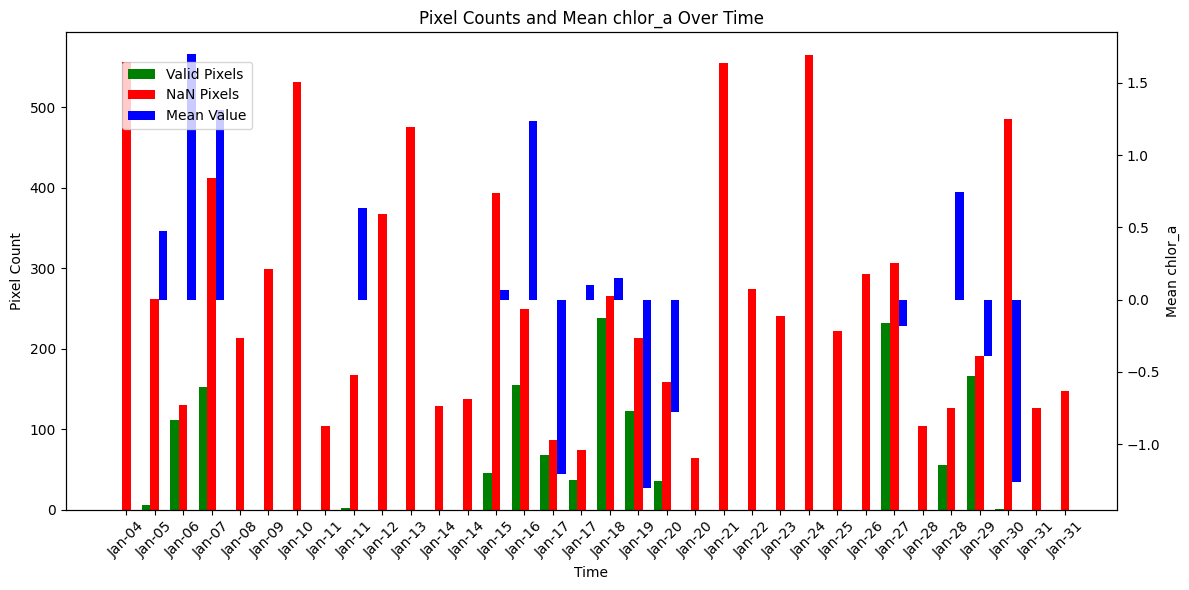

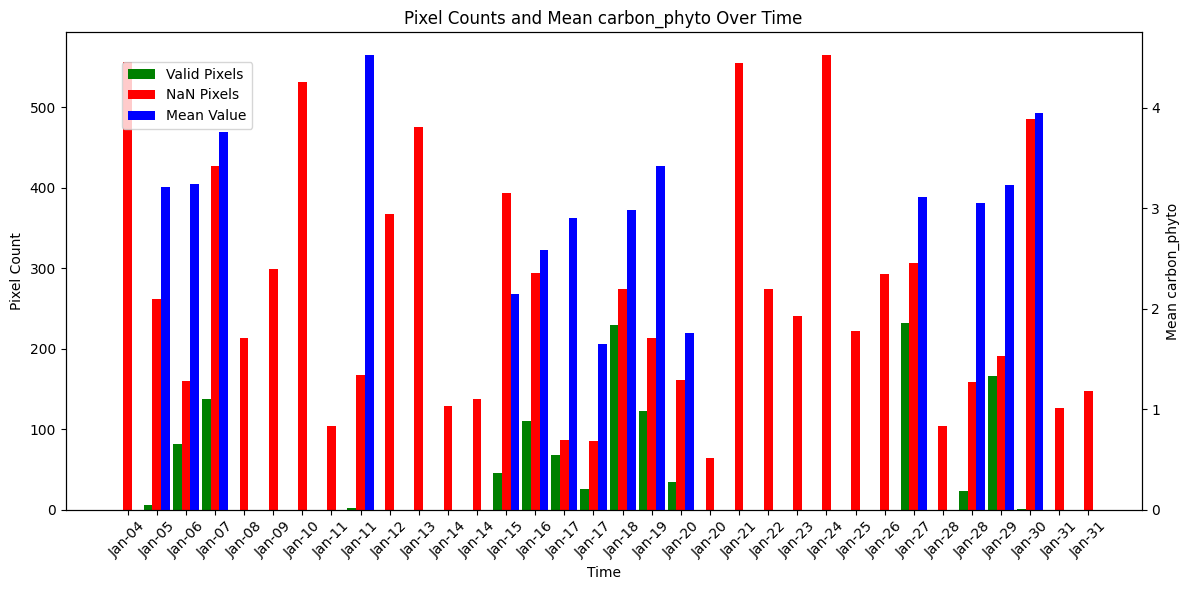

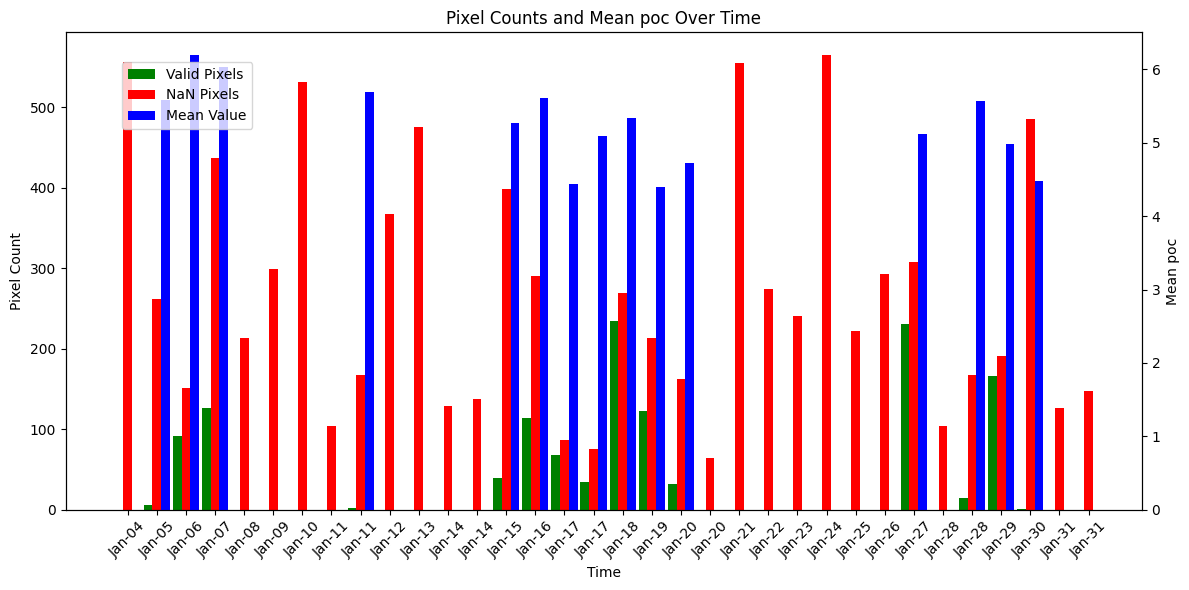

In [31]:
plot_pixel_counts(bgc_summaries, end_date="2025-02-01")

There seems to be a pretty big issue with missing data for January dates. A lot of the dates have no or very few valid pixels. This might be due to cloud cover. An option could be to expand the bounding box to a larger region, though the results would not be as localized and there would still an issue of missing data. 

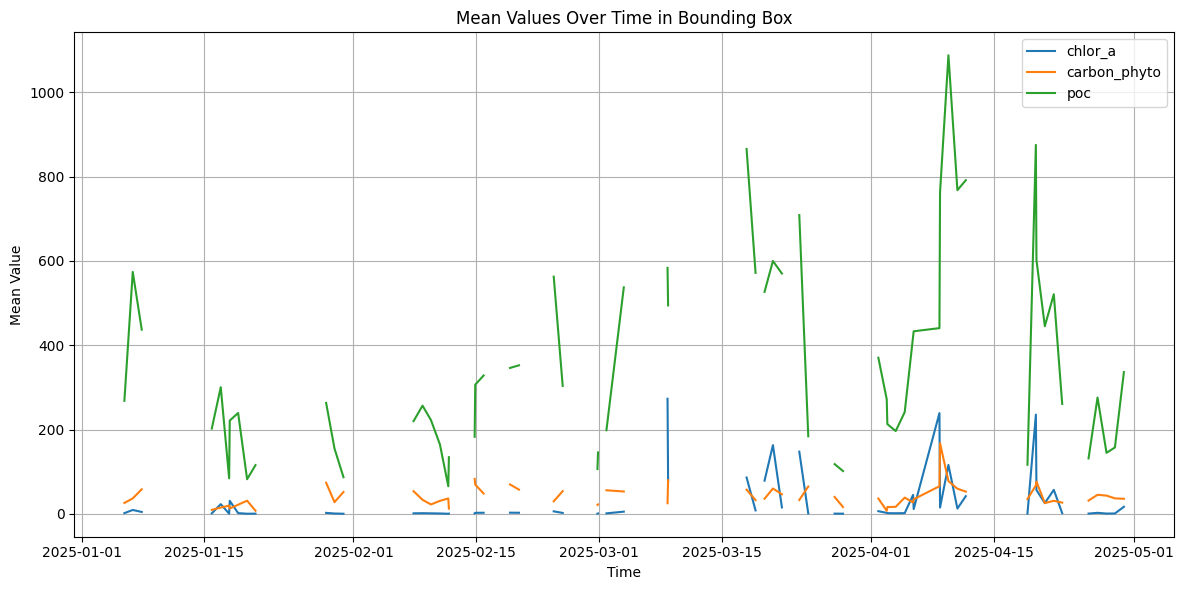

In [17]:
def plot_mean_values(summaries):
    plt.figure(figsize=(12, 6))

    for var_name, records in summaries.items():
        df = pd.DataFrame(records)
        df['time'] = pd.to_datetime(df['time'])
        plt.plot(df['time'], df['mean_value'], label=var_name)

    plt.xlabel("Time")
    plt.ylabel("Mean Value")
    plt.title("Mean Values Over Time in Bounding Box")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mean_values(bgc_summaries)

There seems to be a bit of an upward trend, especially for particulate organic carbon (poc), though there are fluctuations and missing data.

#### BGC Plots with Log Transformations Applied

In [18]:
def apply_transformations(ds, transformations):
    """
    Apply specified transformations to variables in an xarray.Dataset.

    Parameters:
        ds (xarray.Dataset): The dataset to transform.
        transformations (dict): A mapping from variable names to transformation functions.

    Returns:
        xarray.Dataset: A new dataset with transformations applied.
    """
    ds_transformed = ds.copy()
    
    for var_name, func in transformations.items():
        if var_name in ds:
            try:
                ds_transformed[var_name] = func(ds[var_name])
            except Exception as e:
                print(f"Error applying transformation to {var_name}: {e}")
        else:
            print(f"Variable '{var_name}' not found in dataset.")
    
    return ds_transformed

bgc_merged_ds = apply_transformations(bgc_merged_ds, {"chlor_a": np.log, "poc": np.log1p, "carbon_phyto": np.log})

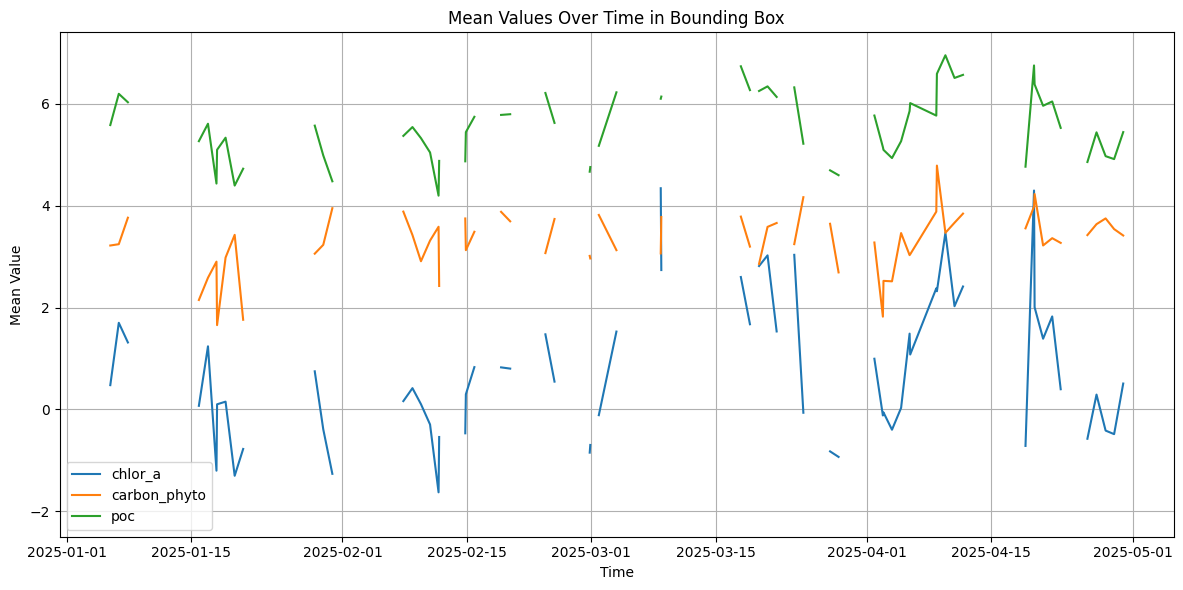

In [ ]:
transformed_bgc_summaries = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a", "carbon_phyto", "poc"], pacific_pal_bbox)
plot_mean_values(transformed_bgc_summaries)

### LANDVI (Land Vegetation Index) Data - NDVI, EVI, NDII, NDWI

NDVI (Normalized Difference Vegetation Index)
- general vegetation health and greeness
- wildfires reduce greenbiomass (drop in NDVI)

EVI (Enhanced Vegetation Index)
- Similar to NDVI but corrects for atmospheric noise and canopy background
- Better in areas with thick vegetation

NDII (Normalized Difference Infrared Index)
- Detects vegetation water stress
- Wildfires dry out vegetation; NDII declines before and after fire

NDWI (Normalized Difference Water Index)
- Measures leaf water content
- Assess water loss in vegetation due to fire

In [21]:
landvi_merged_ds = load_merged_dataset(landvi_dir, ["ndvi", "evi", "ndii", "ndwi"])
landvi_merged_ds


<xarray.Dataset> Size: 7GB
Dimensions:    (time: 143, number_of_lines: 1709, pixels_per_line: 1272)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2025-01-04T20:23:00 ... 2025-04-30T2...
    longitude  (time, number_of_lines, pixels_per_line) float32 1GB -126.2 .....
    latitude   (time, number_of_lines, pixels_per_line) float32 1GB 16.3 ... ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    ndvi       (time, number_of_lines, pixels_per_line) float32 1GB nan ... nan
    evi        (time, number_of_lines, pixels_per_line) float32 1GB nan ... nan
    ndii       (time, number_of_lines, pixels_per_line) float32 1GB nan ... nan
    ndwi       (time, number_of_lines, pixels_per_line) float32 1GB nan ... nan

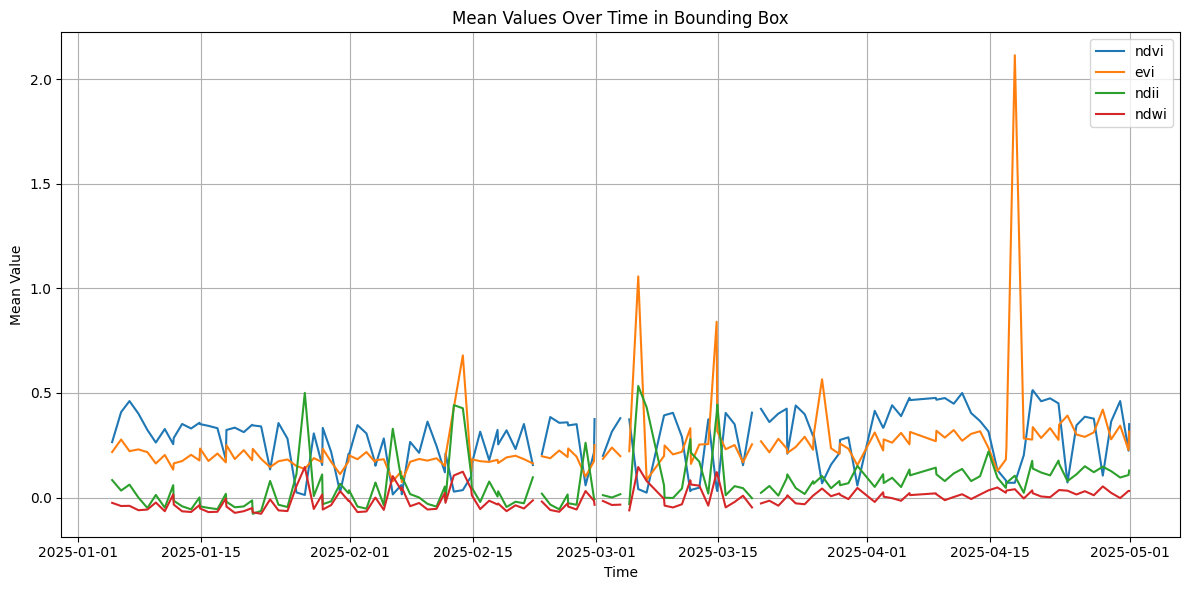

In [23]:
landvi_summaries = summarize_variables_in_bbox(landvi_merged_ds, ["ndvi", "evi", "ndii", "ndwi"], pacific_pal_bbox)
plot_mean_values(landvi_summaries)

The fire occurred Jan 7th and there seems to be a drop in ndvi around that date, though there seems to be a lot of fluctuation throughout. There are a few spikes in ndii and ndwi (vegetation water indices) near the end of January and mid-Febrary, and a few times in March. This makes sense because it lines up with dates where it rained.

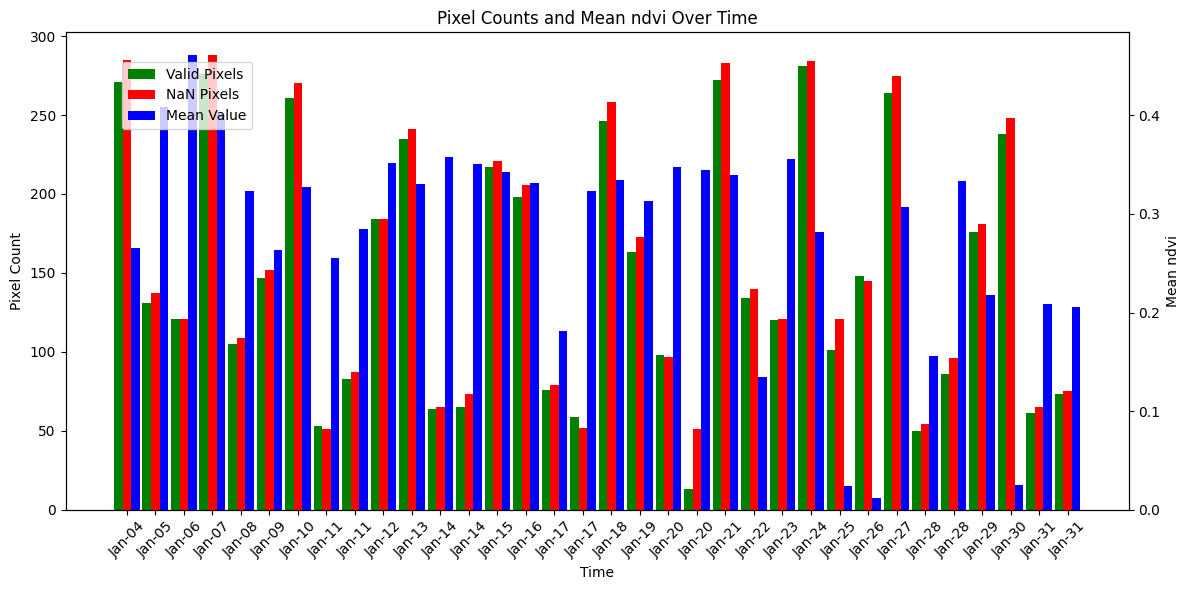

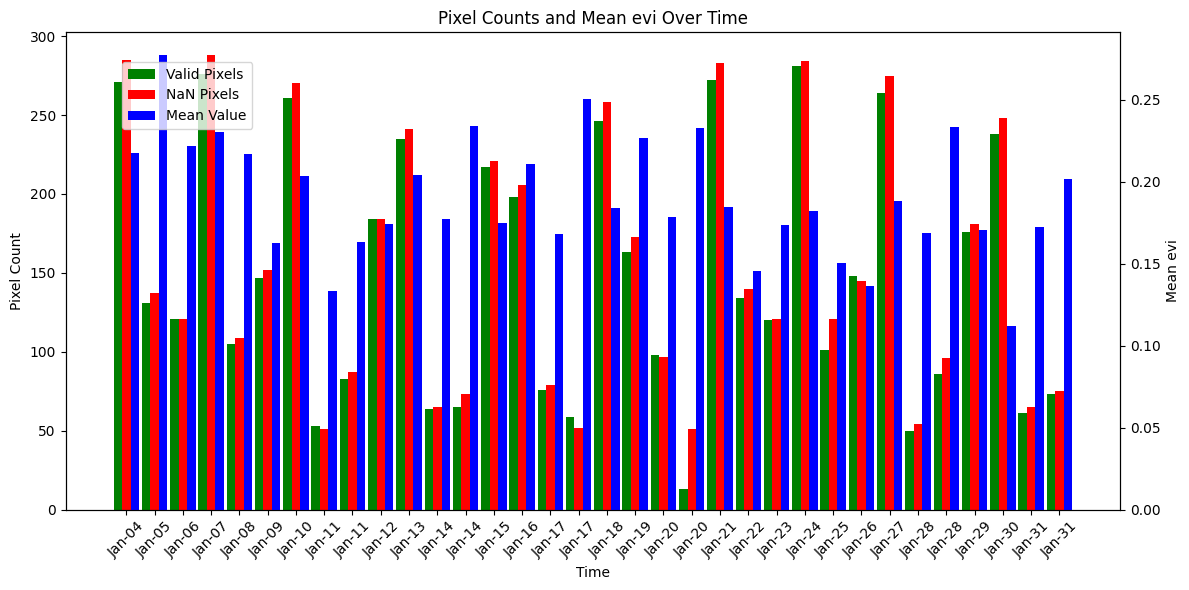

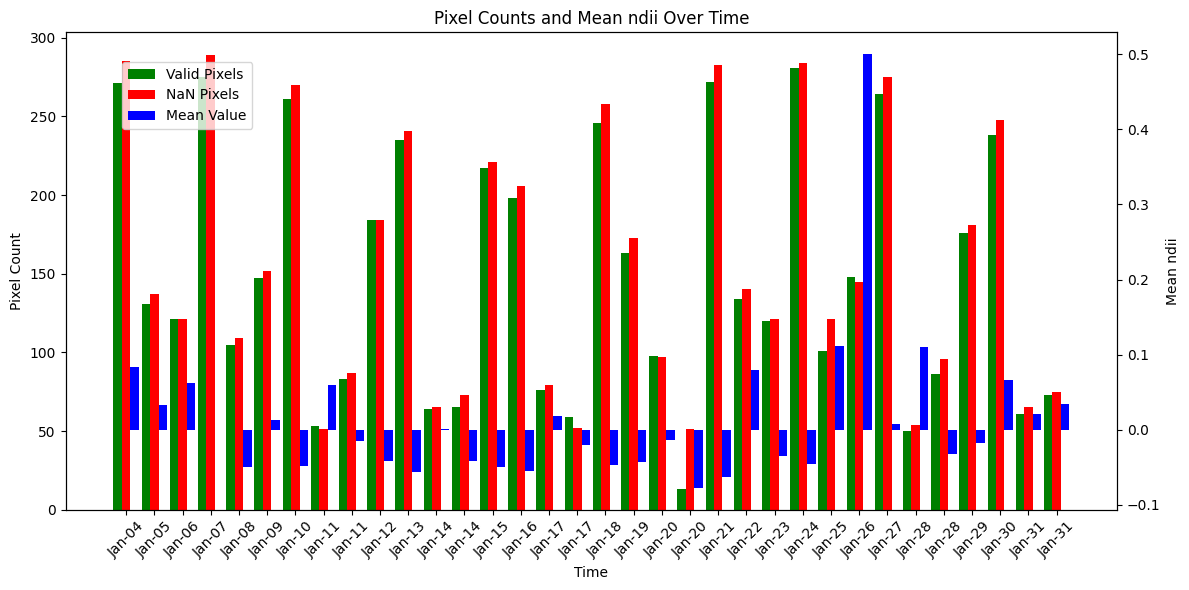

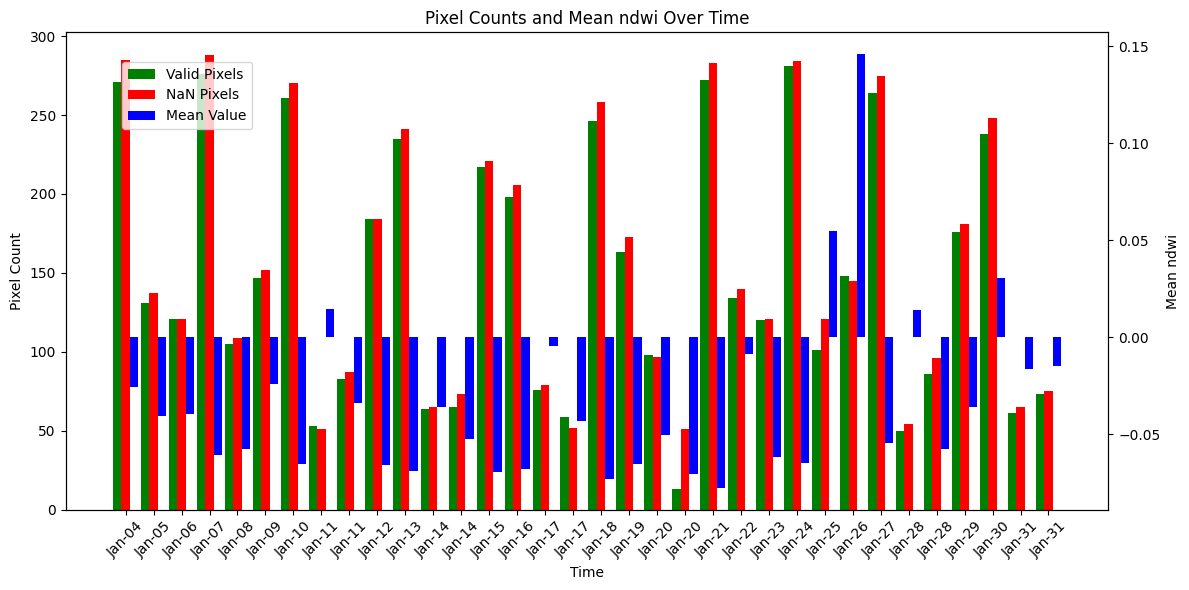

In [ ]:
plot_pixel_counts(landvi_summaries, end_date="2025-02-01")

There seems to be a relatively equal number of valid and NaN pixels for each date which is expected since half of the bounding box is land and half is water. There should only be valid pixels for the land portion for LANDVI data. The pixel counts also seem to be the same between different variables (ndvi, evi, ndwi, ndwi). There doesn't seem to be much issue with missing data spots for LANDVI data compared to BGC data.